엘보우 방법 및 실루엣 계수 시각화 - 최적 클러스터 수 k 선택
실루엣 점수 분석을 사용해 적정 클러스터 수 결정
Silhouette 값이 최대인 경우 적정 클러스터 갯수
    
Elbow method, WSSSE 플롯의 elbow 찾기
WSSSE 최소화하는 클러스터 갯수 k
elbow 방법으로 적정 k를  찾는 것은 어려움

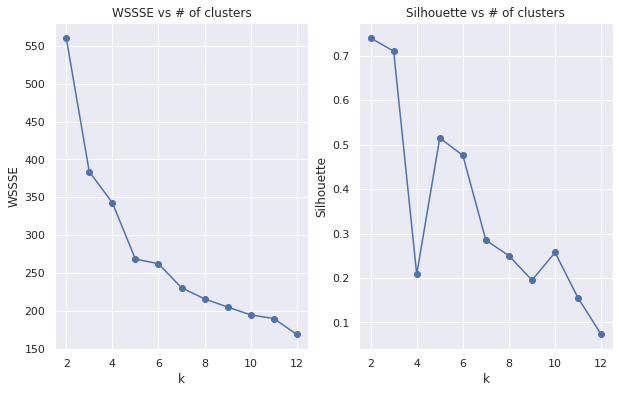

In [7]:
import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from matplotlib.ticker import MaxNLocator

range_k = [2,3,4,5,6,7,8,9,10,11,12]
sil_lst = [0.7398528290653053, 0.7102181254760674, 0.20845298288085098, 0.5147237386775917, 0.47577916759443084, 0.28504052593773516, 0.25001223354165053, 0.19504457280810478, 0.2573453253064011, 0.15483786376378575, 0.0729534808181827]
wssse = [560.2141542549147, 383.8768631204311, 343.0332859143904, 268.6329848414855, 262.62823779197095, 230.79447134334026, 216.2626108607134, 205.43475266394958, 195.08702731196112, 190.30933504239857, 169.259924458042]

silhouette = pd.DataFrame(list(zip(range_k, sil_lst)), columns=['k', 'silhouette'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
# WSS
ax1.plot(silhouette.k, wssse, marker='o')
ax1.set_xlabel('k')
ax1.set_ylabel('WSSSE')
ax1.set_title("WSSSE vs # of clusters")
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# 실루엣 스코어
ax2.plot(silhouette.k, silhouette.silhouette, marker="o")
ax2.set_xlabel('k')
ax2.set_ylabel('Silhouette')
ax2.set_title("Silhouette vs # of clusters")
plt.show()

실루엣분석

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import functions as Fn
from pyspark.sql.functions import when, col
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler

spark = SparkSession.builder.getOrCreate()

data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_daily_features")
#data.select([Fn.count(Fn.when(Fn.isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).show()
df = data.toPandas()

# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# DCU ID를 Integer 라벨로 변환
le = LabelEncoder()
le.fit(df[dcu_cols])
df["dcu_label"] = le.transform(df[dcu_cols])

# Integer 라벨을 이진 벡터로 표현
ohe = OneHotEncoder()
x = ohe.fit_transform(df.dcu_label.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(x, columns = ["dcu_"+str(int(i)) for i in range(x.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)

# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

# one hot encoded columns 추가
input_cols.extend(dfOneHot.columns)

For n_clusters = 5 The average silhouette_score is : 0.26096707302545435
For n_clusters = 7 The average silhouette_score is : 0.2524332161692083


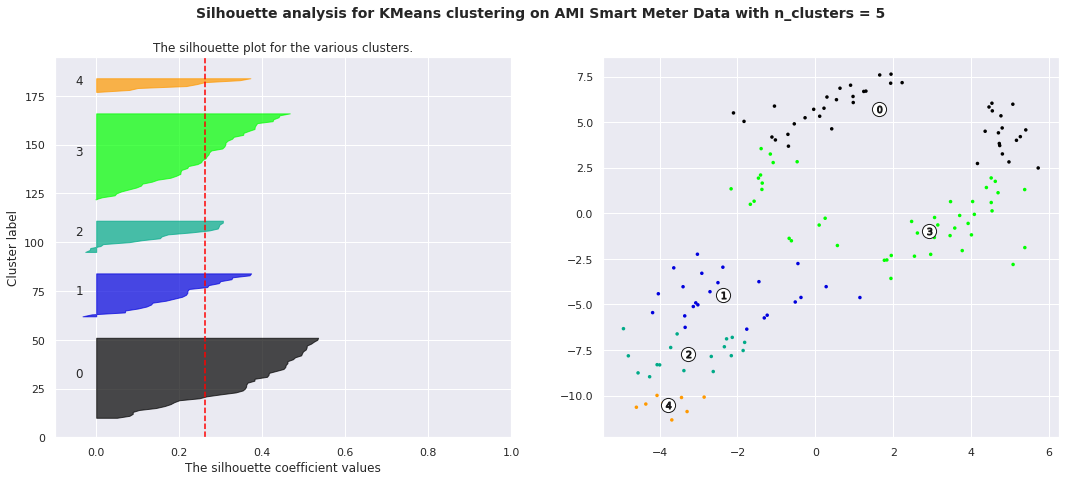

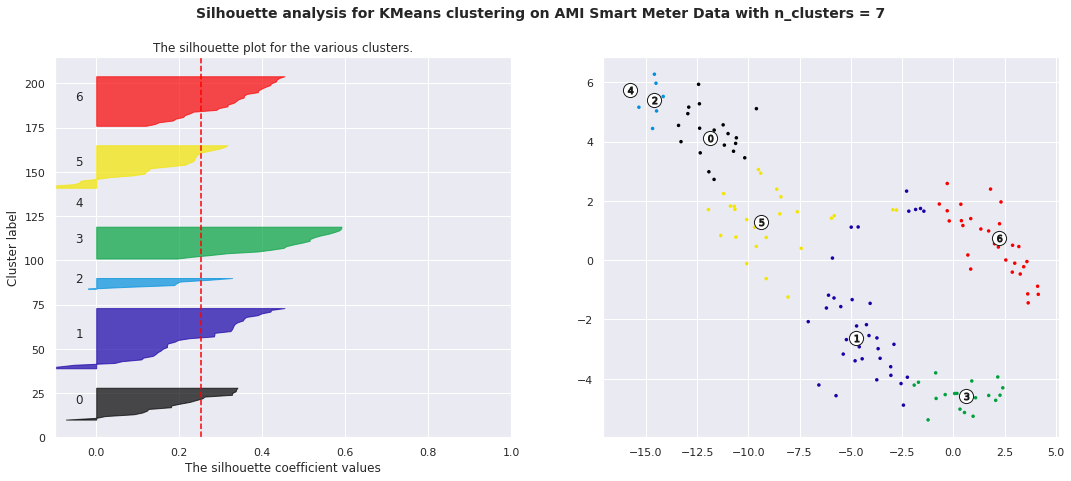

In [15]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# 클러스터 개수
range_n_clusters = [5, 7]

for n_clusters in range_n_clusters:
    # 1행 2열의 그래프
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # 실루엣 계수 플롯 (실루엣 계수는 -1 ~ 1)
    ax1.set_xlim([-0.1, 1])
    # 각각의 클러스터의 실루엣 계수 플롯 간 공백 The (n_clusters+1)*10
    ax1.set_ylim([0, len(df[input_cols]) + (n_clusters + 1) * 10])

    # n_clusters 값으로 K-Means 모델 초기화
    clusterer = KMeans(n_clusters=n_clusters, random_state=1234, algorithm='auto')
    cluster_labels = clusterer.fit_predict(df[input_cols])

    # silhouette_score는 모든 데이터들에 대한 평균 값을 계산
    # 실루엣 스코어를 통해 클러스터들의 밀도와 간격에 대한 정보를 얻을 수 있음
    silhouette_avg = silhouette_score(df[input_cols], cluster_labels)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # 각 데이터에 대해 실루엣 계수 계산
    sample_silhouette_values = silhouette_samples(df[input_cols], cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # 클러스터 i에 속하는 데이터들에 대한 실루엣 계수 집계 및 정렬
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        # 클러스터 i의 크기
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values,\
                        facecolor=color, edgecolor=color, alpha=0.7)

        # 실루엣 계수 플롯 시 중간에 클러스터 i 라벨링
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # 다음 클러스터에 대한 y 값 계산
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # 모든 데이터들에 대한 평균 실루엣 계수를 나타내는 수직선
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    #ax1.set_yticks([])  # Clear the yaxis labels / ticks
    #x1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 클러스터 중심과 함께 클러스터 플롯
    # 기존 특징 데이터에 center 데이터를 concat, 135부터는 클러스터 중심
    # centers는 각 특징 컬럼에 대한 중심 좌표를 갖고 있음
    centers = clusterer.cluster_centers_
    centers_df = pd.DataFrame(centers, columns=df[input_cols].columns)
    all_df = pd.concat([df[input_cols], centers_df])
    # t-distributed Stochasic Neighbor Algorithm (t-SNE), 클러스터 내 데이터 포인트들을 유지하는 비선형 manifold alogorithm을 사용하여 데이터 차원을 2차원으로 축소
    tsne = TSNE(n_components=2, init="pca", random_state=0)
    df_reduce = tsne.fit_transform(all_df)
    
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    # 데이터 포인트 플롯
    #ax2 = fig.add_subplot(projection='3d')
    ax2.scatter(df_reduce[:135, 0], df_reduce[:135, 1], marker='.', s=50, lw=0, alpha=1, c=colors, edgecolor='k')

    # 클러스터 중심 플롯 
    ax2.scatter(df_reduce[135:, 0], df_reduce[135:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')
    cen = df_reduce[135:]
    for i, c in enumerate(cen):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    #ax2.set_title("The visualization of the clustered data.")
    #ax2.set_xlabel("Feature space for the 1st embedded feature")
    #ax2.set_ylabel("Feature space for the 2nd embedded feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on AMI Smart Meter Data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

클러스터 히스토그램
클러스터 시각화를 위해 Spark DataFrame을 Pandas DataFrame으로 변환
#clusters5_df["LP_METER_ID"] = pd.to_numeric(clusters5_df["LP_METER_ID"]) 변환되지 않음
#clusters5_df.LP_METER_ID = clusters5_df.LP_METER_ID.apply(lambda x: str(x)) 변환되지 않음
pandasDF["distanceFromCenter"] = pd.to_numeric(pandasDF["distanceFromCenter"]) 불필요

In [16]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

clusters5 = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/k-means-clusters")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135 entries, 0 to 134
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   LP_METER_ID         135 non-null    int64  
 1   prediction          135 non-null    int32  
 2   distanceFromCenter  135 non-null    float64
 3   max_distance        135 non-null    float64
 4   anomaly             135 non-null    int32  
dtypes: float64(2), int32(2), int64(1)
memory usage: 4.3 KB
1
1
1
5
1


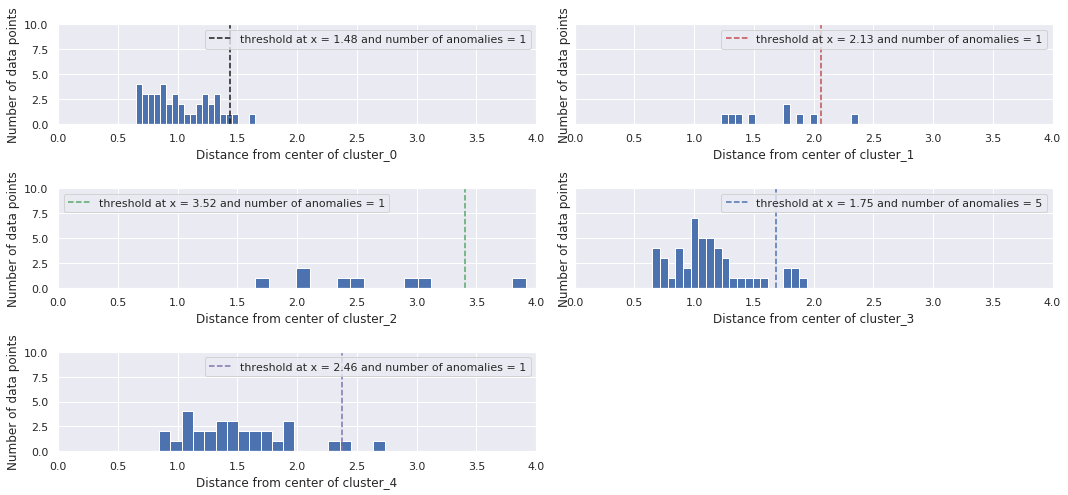

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

clusters5_df = clusters5.toPandas()
clusters5_df["LP_METER_ID"] = pd.to_numeric(clusters5_df["LP_METER_ID"])
clusters5_df.info()

n_clusters = [0, 1, 2, 3, 4]
colors = ['k','r','g','b','m']
fig, axes = plt.subplots(3, 2, figsize=(15, 7), sharey=True)
axes = axes.flatten()

for i in n_clusters:
    cluster_i = clusters5_df[clusters5_df["prediction"] == i]
    max_distance_cluster_i = cluster_i.max_distance.values[0].round(2)
    number_of_anomalies_i = cluster_i[["prediction"]][cluster_i["anomaly"] == 1].count()[0]
    print(number_of_anomalies_i)
    axes[i].hist(x=cluster_i.distanceFromCenter, bins=20)
    axes[i].axvline(x=max_distance_cluster_i*0.87, color=colors[i], linestyle="--",\
            label="threshold at x = %.2f and number of anomalies = %d" % (max_distance_cluster_i*0.9, number_of_anomalies_i))
    axes[i].set_xlabel("Distance from center of cluster_"+str(i))
    axes[i].set_ylabel("Number of data points")
    axes[i].set_xlim(0, 4)
    axes[i].set_ylim(0, 10)
    plt.tight_layout()
    axes[i].legend()
#fig.delaxes(axes[5])
axes[5].set_axis_off()
plt.show()

클러스터 시각화

In [20]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

data = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/cs_daily_features")

anomaly_id = spark.read.orc("hdfs://nameserver/apps/spark/warehouse/meter_id_list_k_means")
anomaly_id_list_spark_k_means = [ row["LP_METER_ID"] for row in anomaly_id.collect()]

In [21]:
# Spark Dataframe to Pandas Dataframe
df = data.toPandas()

# IQR NTL Meter Index
anomaly = df.loc[ df.LP_METER_ID.isin(anomaly_id_list_spark_k_means) ]
anomaly_index_spark_k_means = list(anomaly.index)
anomaly_index_spark_k_means

[15, 22, 57, 60, 63, 69, 82, 89, 91]

In [22]:
# 학습 입력 컬럼
input_cols = df.columns[2:].tolist()
dcu_cols = df.columns[1]

# DCU ID를 Integer 라벨로 변환
le = LabelEncoder()
le.fit(df[dcu_cols])
df["dcu_label"] = le.transform(df[dcu_cols])

# Integer 라벨을 이진 벡터로 표현
ohe = OneHotEncoder()
x = ohe.fit_transform(df.dcu_label.values.reshape(-1,1)).toarray()
dfOneHot = pd.DataFrame(x, columns = ["dcu_"+str(int(i)) for i in range(x.shape[1])]) 
df = pd.concat([df, dfOneHot], axis=1)

# 데이터 정규화
scaler = MinMaxScaler()
scaler.fit(df[input_cols])
df[input_cols]= scaler.transform(df[input_cols])

# one hot encoded columns 추가
input_cols.extend(dfOneHot.columns)

No handles with labels found to put in legend.


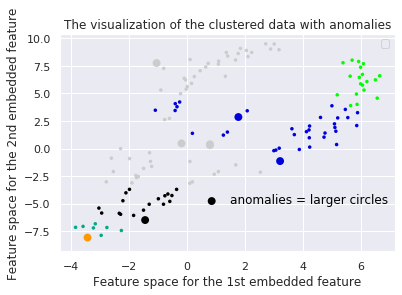

In [23]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

n_clusters = 5
tsne = TSNE(n_components=2, init="pca", random_state=0)
df_reduce = tsne.fit_transform(df[input_cols])
colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
#fig, ax = plt.subplots()
#ax = fig.add_subplot(projection='3d')
# 데이터 포인트 플롯
plt.scatter(df_reduce[:135, 0], df_reduce[:135, 1], marker='.', s=50, lw=0, alpha=1, c=colors, edgecolor='k')

# 이상 데이터 포인트 플롯
plt.scatter(df_reduce[anomaly_index_spark_k_means, 0], df_reduce[anomaly_index_spark_k_means, 1], marker='.', s=250, lw=0, alpha=1, c=colors[anomaly_index_spark_k_means], edgecolor='k')

plt.title("The visualization of the clustered data with anomalies")
plt.xlabel("Feature space for the 1st embedded feature")
plt.ylabel("Feature space for the 2nd embedded feature")
plt.text(1.5, -5, s='anomalies = larger circles', fontsize=12, color='black')
plt.legend()
plt.show()